In [1]:
#@title Imports { display-mode: "form" }

# !pip install --quiet --upgrade dm-haiku optax 
# !pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git
# !pip install --quiet chainconsumer
# !pip install --quiet numpyro

import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())


%pylab inline
import arviz as az
az.style.use("arviz-white")
import jax
import jax.numpy as jnp
import haiku as hk
import optax
from tqdm import tqdm
from functools import partial
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP, AffineCoupling
from sbids.tasks.two_moons import get_two_moons
from jax.experimental.ode import odeint
# from sbids.train_models import train_model
import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

from jax.random import PRNGKey as key

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Create toy gaussian model

In [2]:
# numpyro model

prior = dist.MultivariateNormal(0.5*jnp.ones(2), jnp.eye(2) / 300)
proposal = dist.MultivariateNormal(jnp.ones(2) * 0.55, jnp.array([4, 6]) * jnp.eye(2)/ 3000)

def gaussian_model_prior(): 

  theta = numpyro.sample(
      'theta', 
      prior
    )

  y = numpyro.sample(
      'y', 
      dist.MultivariateNormal(theta, jnp.array([2, 4]) * jnp.eye(2) / 5000 )
    )
  
  return y


def gaussian_model_proposal(): 

  theta = numpyro.sample(
      'theta', 
      proposal
    )

  y = numpyro.sample(
      'y', 
      dist.MultivariateNormal(theta, jnp.array([2, 4]) * jnp.eye(2) / 4000 )
    )
  
  return y

In [3]:
keys = jax.random.split(key(0), 100000)
prior_sample = jax.vmap(lambda key : trace(seed(gaussian_model_prior, key)).get_trace()['theta']['value'])(keys)
proposal_sample = jax.vmap(lambda key : trace(seed(gaussian_model_proposal, key)).get_trace()['theta']['value'])(keys)

2023-04-14 09:51:31.321660: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:219] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f32[2,100000]{1,0} custom-call(f32[2,2]{1,0} %Arg_0.1, f32[2,100000]{0,1} %bitcast.11), custom_call_target="__cublas$gemm", metadata={op_name="jit(matmul)/jit(main)/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/numpyro/distributions/continuous.py" source_line=1139}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"precision_config\":{\"operand_precision\":[\"DEFAULT\",\"DEFAULT\"]},\"epilogue\":\"DEFAULT\"}" failed. Falling back to default algorithm

In [4]:
x0 = jnp.ones(2) * 0.5
observed_model = condition(gaussian_model_prior, {'y': x0})

nuts_kernel = numpyro.infer.NUTS(
    observed_model,
    step_size=1e-2,
    init_strategy=numpyro.infer.init_to_median,
    max_tree_depth=4,
    dense_mass=True
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=20000,
    num_chains=1,
    progress_bar=True
)

mcmc.run(key(0))
samples_mcmc = mcmc.get_samples()

2023-04-14 09:51:32.897119: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:219] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f32[2,15]{0,1} custom-call(f32[2,2]{1,0} %Arg_0.1, f32[2,15]{0,1} %bitcast.13), custom_call_target="__cublas$gemm", metadata={op_name="jit(matmul)/jit(main)/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/numpyro/distributions/continuous.py" source_line=1139}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"precision_config\":{\"operand_precision\":[\"DEFAULT\",\"DEFAULT\"]},\"epilogue\":\"DEFAULT\"}" failed. Falling back to default algorithm.  Per-a

/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


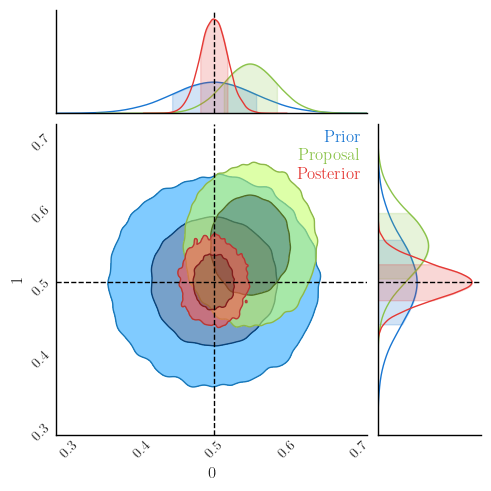

In [5]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(prior_sample, name = 'Prior')
c.add_chain(proposal_sample, name = 'Proposal')
c.add_chain(samples_mcmc['theta'], name = 'Posterior')

fig = c.plotter.plot(figsize="column", truth = list(x0))

# Experiments To do

Test to do with **Not Smooth NF**

    1.  Learn the posterior from the prior
      a. with nll loss
      b. with apt loss 

    -> should get the same contours. 

    If validated:

    2.  Learn the posterior from the proposal
      a. with nll loss
      b. with apt loss 

    -> if it works then apt loss is validated and we can test it on our smooth nf

Do the same steps with **Smooth NF**.






In [130]:
SMOOTH = False
PROPOSAL = True
LOSS_APT = True

In [131]:
master_seed = jax.random.PRNGKey(0)
batch_size = 256
nb_atoms = 50

# SBI

In [133]:
from sbids.tasks.utils import get_samples_and_scores

if PROPOSAL: 
  model = gaussian_model_proposal
  
else: 
  model = gaussian_model_prior


@jax.jit
def get_batch(seed):
  nb_sample = nb_atoms * batch_size # (batch_size * (nb_atoms - 1)) + batch_size)
  (_, samples), score = get_samples_and_scores(
      model, 
      seed, 
      nb_sample
  )

  batch = {
      'x': samples['theta'][:batch_size], 
      'y': samples['y'][:batch_size], 
      'atoms': samples['theta'][batch_size:].reshape([batch_size, -1, 2])
  }

  return batch

In [134]:
# nf model

if SMOOTH: 
  bijector = partial(
    AffineSigmoidCoupling, 
    layers = [256, 256, 256],
    n_components = 16, 
    activation = jax.nn.silu
  )

else:
  bijector = partial(
      AffineCoupling, 
      layers = [256, 256, 256],
      activation = jax.nn.silu
  )

NF = partial(
    ConditionalRealNVP, 
    n_layers = 4, 
    bijector_fn = bijector
)

model_nf = hk.without_apply_rng(hk.transform(
    lambda x, y : NF(2)(y).log_prob(x))
)

In [135]:
# create loss: 

if LOSS_APT: 

  def loss_fn(params, batch):
    @jax.vmap
    def apt_nll(theta, obs, atoms):
      """ Compute the APT NLL for one element in the batch
      """
      # First we sample a bunch of other proposals
      atoms = jnp.concatenate([theta.reshape([1, -1]), atoms], axis=0)

      # Then we repeat the observations
      obs = obs.reshape([1, -1]).repeat(nb_atoms, axis=0)

      # We can now compute the unormalized nll, and return the normalized version
      unormalized_nll = model_nf.apply(params, atoms, obs) - prior.log_prob(atoms)

      return unormalized_nll[0] - jax.nn.logsumexp(unormalized_nll)

    return - jnp.mean(apt_nll(batch['x'], batch['y'], batch['atoms']))


else: 
  def loss_fn(params, batch):

      log_prob_posterior = jax.vmap(
          lambda theta, x: model_nf.apply(
            params, 
            theta.reshape([1,2]), 
            x.reshape([1,2])
          )
      )(batch['x'], batch['y'])

      return -jnp.mean(log_prob_posterior) 

In [136]:
# update function 

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [137]:
# training 

rng_seq = hk.PRNGSequence(12)
params_nd = model_nf.init(
    next(rng_seq), 
    x=jnp.zeros([1,2]), 
    y=jnp.zeros([1,2])
)

# Define a scheduler for the leaerning rate
total_steps = 1000
lr_scheduler = optax.piecewise_constant_schedule(init_value=0.0001,
                  boundaries_and_scales={int(total_steps*0.2):0.5,
                                         int(total_steps*0.5):0.5,
                                         int(total_steps*0.75):0.5})
optimizer = optax.adam(lr_scheduler)
# optimizer = optax.chain(
#   optax.adaptive_grad_clip(1e-4, eps=1e-5),
#   optax.adam(learning_rate=lr_scheduler),
# )

opt_state = optimizer.init(params_nd)

batch_loss = []
for step in tqdm(range(1000)):

    new_key, master_seed = jax.random.split(master_seed)
    batch = get_batch(new_key)

    l, params_nd, opt_state = update(
        params_nd, 
        opt_state, 
        batch
    )
    batch_loss.append(l)
    if jnp.isnan(l):
      break

  0%|          | 0/1000 [00:00<?, ?it/s]

ok


100%|██████████| 1000/1000 [01:27<00:00, 11.37it/s]


Text(0.5, 1.0, 'loss')

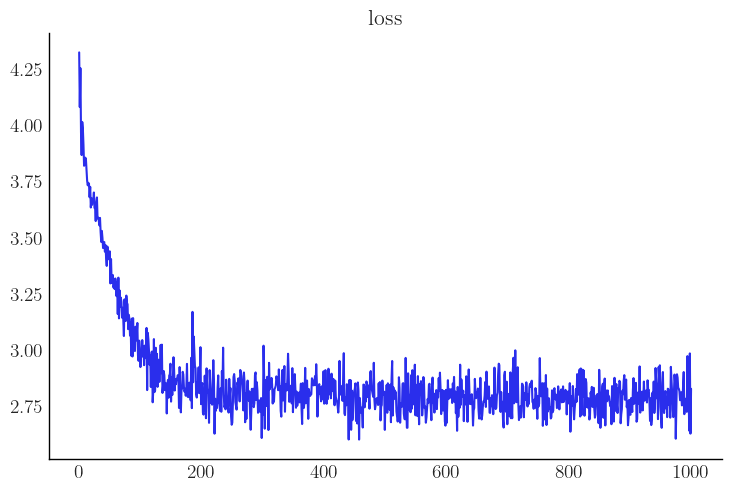

In [138]:
plot(batch_loss)
title('loss')

In [139]:
sample_model = hk.transform(
      lambda x :  NF(2)(x).sample(100000, seed=hk.next_rng_key())
)

predicted_sample = sample_model.apply(
    params_nd, 
    rng = next(rng_seq),
    x = x0 * jnp.ones([100000, 2])
)

/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


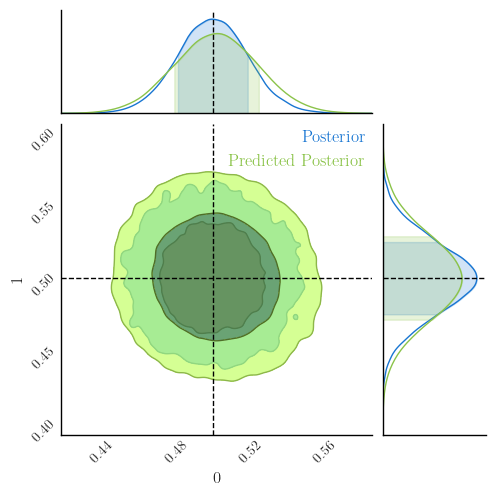

In [140]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(samples_mcmc['theta'], name = 'Posterior')
c.add_chain(predicted_sample, name = 'Predicted Posterior')

fig = c.plotter.plot(figsize="column", truth = list(x0))